# CIFAR10の画像の高解像度化

In [1]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [3]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
print(x_train.shape)
print(x_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [4]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model

In [5]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        print(e)

In [6]:
import tensorflow as tf

if tf.test.is_built_with_cuda():
    print("GPU is available")
    devices = tf.config.list_physical_devices('GPU')
    print("Number of available GPUs:", len(devices))
else:
    print("GPU is not available")


GPU is available
Number of available GPUs: 0


In [9]:
input_img = Input(shape=(32, 32, 3))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
print(x.shape)
x = MaxPooling2D((2, 2), padding='same')(x)
print(x.shape)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = MaxPooling2D((2, 2), padding='same')(x)
print(x.shape)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
encoded = MaxPooling2D((2, 2), padding='same')(x)
print(encoded.shape)

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
print(x.shape)
x = UpSampling2D((2, 2))(x)
print(x.shape)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = UpSampling2D((2, 2))(x)
print(x.shape)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
print(x.shape)
x = UpSampling2D((2, 2))(x)
print(x.shape)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
print(decoded.shape)
autoencoder = Model(input_img, decoded)

(None, 32, 32, 16)
(None, 16, 16, 16)
(None, 16, 16, 8)
(None, 8, 8, 8)
(None, 8, 8, 8)
(None, 4, 4, 8)
(None, 4, 4, 8)
(None, 8, 8, 8)
(None, 8, 8, 8)
(None, 16, 16, 8)
(None, 16, 16, 16)
(None, 32, 32, 16)
(None, 32, 32, 3)


In [24]:
from keras import backend as K

In [25]:
def psnr(y_true, y_pred):
    return -10*K.log(K.mean(K.flatten((y_true - y_pred))**2))/np.log(10)

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath="weights/autoencoder-epoch-{epoch:02d}.h5"

# エポック数が10の倍数のときにのみチェックポイントを保存するコールバック
checkpoint = ModelCheckpoint(filepath, save_weights_only=True, save_freq=2)
# checkpoint = ModelCheckpoint(filepath, save_weights_only=True, save_freq=10)

# コールバックをリストにまとめる
callbacks_list = [checkpoint]

from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.01)

# モデルをコンパイルする
autoencoder.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[psnr])

# モデルを学習する
autoencoder.fit(x_train, x_train, epochs=10, batch_size=128, shuffle=True, validation_data=(x_test, x_test), callbacks=callbacks_list)

Epoch 1/10
391/391 [==============================] - 7s 17ms/step - loss: 0.5945 - psnr: 17.4868 - val_loss: 0.5838 - val_psnr: 18.4393
Epoch 2/10
391/391 [==============================] - 7s 18ms/step - loss: 0.5818 - psnr: 18.5810 - val_loss: 0.5812 - val_psnr: 18.7605
Epoch 3/10
391/391 [==============================] - 7s 17ms/step - loss: 0.5809 - psnr: 18.7002 - val_loss: 0.5840 - val_psnr: 18.4529
Epoch 4/10
391/391 [==============================] - 7s 17ms/step - loss: 0.5803 - psnr: 18.7804 - val_loss: 0.5804 - val_psnr: 18.8505
Epoch 5/10
391/391 [==============================] - 7s 17ms/step - loss: 0.5797 - psnr: 18.8644 - val_loss: 0.5829 - val_psnr: 18.5839
Epoch 6/10
391/391 [==============================] - 7s 18ms/step - loss: 0.5791 - psnr: 18.9432 - val_loss: 0.5785 - val_psnr: 19.1370
Epoch 7/10
391/391 [==============================] - 7s 18ms/step - loss: 0.5789 - psnr: 18.9776 - val_loss: 0.5789 - val_psnr: 19.0733
Epoch 8/10
391/391 [=====================

In [27]:
def show_img(model, filepath, test_img):
    model.load_weights(filepath)
    decoded_imgs = model.predict(test_img)
    
    n = 10
    plt.figure(figsize=(20, 4))
    
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(decoded_imgs[i].reshape(32, 32, 3))
        plt.gray()
    plt.show()

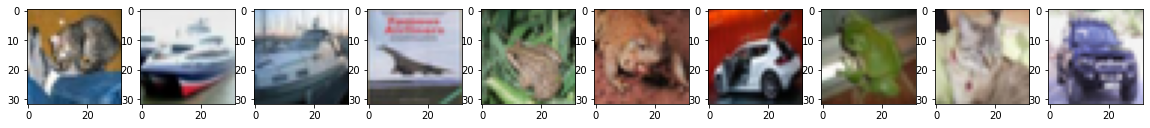

In [28]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test[i].reshape(32, 32, 3))
    plt.gray()

313/313 [==============================] - 1s 2ms/step


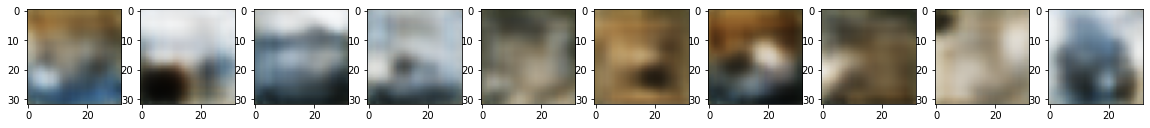

313/313 [==============================] - 1s 2ms/step


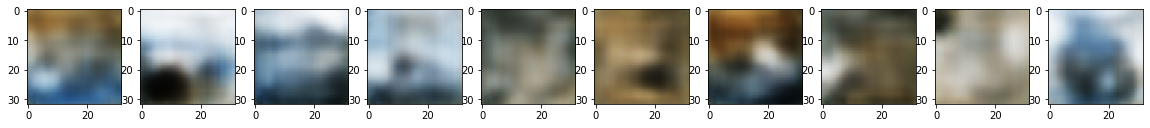

313/313 [==============================] - 1s 2ms/step


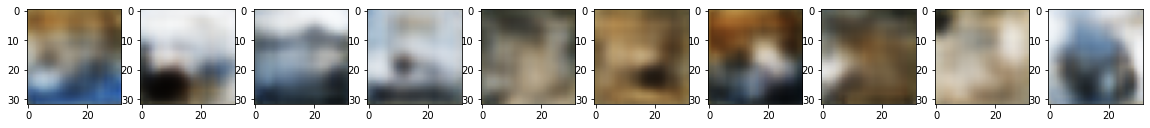

313/313 [==============================] - 0s 1ms/step


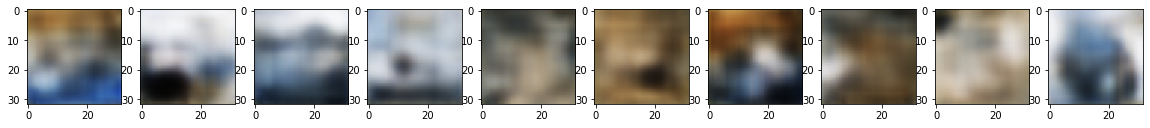

313/313 [==============================] - 1s 2ms/step


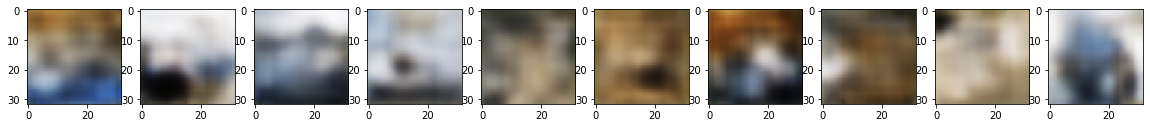

In [29]:
for i in range(2, 11, 2):
    x = str(i)
    if len(x) == 1:
        x = '0' + x
    filepath = 'weights/autoencoder-epoch-' + str(x) + '.h5'
    show_img(autoencoder, filepath, x_test)
    